<a href="https://colab.research.google.com/github/fernandofsilva/thesis/blob/main/Op%C3%A7%C3%B5es_Redes_Neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

In [4]:
#@title Carregando os dados preprocessados
data = pd.read_csv(f'/content/drive/My Drive/Datasets/data_option.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,option,value,X,expire,option_type,T,S,return,r,sigma,bs,delta_bs
0,2015-01-05,PETRM2,0.02,4.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.00,0
1,2015-01-05,PETRM23,0.79,9.21,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.87,63
2,2015-01-05,PETRM25,1.13,9.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,1.16,73
3,2015-01-05,PETRM51,0.15,7.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.14,18
4,2015-01-05,PETRM16,7.13,15.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,7.23,100


# Pré processamento LSTM

Diferente da rede neural que trata os dados de forma independente no tempo, a rede LSTM utiliza das sequências de dados para fazer a predição dos valores, com isso é adicionada uma nova dimensão nos dados (tempo ou qualquer dado que seja sequencial).

Algumas opções não são negociadas todos os dias e também há opções com diferentes tamanhos de tempo (opções de 1 mês, 2 meses e até mais de um ano). Mesmo que as redes recorrentes aceitem dimensões de tempos diferentes no treinamento, testes anteriores mostraram um grande esforço para dimensionamento e inserção desses dados na rede e resultados poucos satisfatórios com essa abordagem.

Com isso foi padronizado um tamanho de dados de 50 dias. Assim, opções com dias de negócio menor que 50, tiveram seu tamanho alongado através de padding, ou seja, foram adicionadas dados em branco para que a janela de tempo fosse fixa em 50 dias, isso não prejudicou o treinamento, uma vez que não há valores de opção R$ **0.00**

In [5]:
#@title Padding com time steps de 50 dias
# Create reference dataframe
reference = data.groupby(['expire', 'option', 'option_type'], as_index=False).agg({'date': 'count'})
reference = reference.drop(['date'], axis=1)

# Create empty dataframe to append data
df = pd.DataFrame()

# Loop over the reference dict
for index, row in reference.iterrows():

    # Filter the data according the options
    subset = data[(data['expire'] == row['expire']) & (data['option'] == row['option'])]

    # Calcule the size of the data
    size = 50 - subset.shape[0]

    if size > 0:
        # Create padding data
        subset = pd.DataFrame({'date': pd.date_range(start='1/1/2014', periods=size),
                    'option': [row['option']] * size,
                    'value': [0] * size,
                    'X': [0] * size,
                    'expire': [row['expire']] * size,
                    'option_type': [row['option_type']] * size,
                    'T': [0] * size,
                    'S': [0] * size,
                    'return': [0] * size,
                    'r': [0] * size,
                    'sigma': [0] * size,
                    'bs': [0] * size,
                    'delta_bs': [0] * size
        }).append(subset)
    else:
        subset = subset[-50:]

    # Append in the dataframe
    df = df.append(subset)

# Assign to data variable
data = df
del df

# Order data
data = data.sort_values(by=['expire', 'option', 'date'])
data = data.reset_index()
data = data.drop(['index'], axis=1)
data.head()

,date,option,value,X,expire,option_type,T,S,return,r,sigma,bs,delta_bs
0,2014-01-01,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2014-01-02,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2014-01-03,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2014-01-04,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2014-01-05,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0


# Dividindo os dados entre treino, teste e validação

O periodo dos dados é composto de janeiro de 2015 até março de 2020. Assim, os dados de treino e teste pertencem ao periodo de janeiro de 2015 até dezembro de 2019, com uma divisão de 70% treino e 30% teste e os dados de validação pertecem ao periodo de janeiro de 2020 até março de 2020.

Para a divisão entre treino e teste, foi utilizada a seguinte métodologia:

- Os dados foram divididos considerando a data de vencimento da opção
- Após selecionada as opções dentro do mesmo vencimento, a divisão entre treino e teste foi feito da maneira aleatória, considerando a divisão 70/30.


In [6]:
#@title Treino, teste e validação

# Define validation data
val = data[data['expire'] > '2020-01-01']
data = data[data['expire'] < '2020-01-01']

# Define train size dataframe percentage
train_size = .75

# Get list with unique expire date
expire_list = data['expire'].sort_values().unique()

# Create stratify column
data['stratify'] = ''

# Loop over the expire list 
for date in expire_list:

    # Get options from expire date
    option_list = data.loc[data['expire'] == date, 'option'].unique()

    # Calculate the size of ta
    size = int(option_list.shape[0] * train_size)

    # Generate random list of integers
    random_list = np.random.choice(range(option_list.shape[0]), size, replace=False)

    # Subset options randomly between train and test
    option_train = option_list[random_list]
    option_test = np.delete(option_list, random_list, None)

    data.loc[(data['expire'] == date) & (data['option'].isin(option_train)), 'stratify'] = 'train'
    data.loc[(data['expire'] == date) & (data['option'].isin(option_test)), 'stratify'] = 'test'

train = data[data['stratify'] == 'train']
test = data[data['stratify'] == 'test']

# Engenharia das variáveis (Feature Engineering)

Essa sessão é composta da transformação dos dados para entrada na rede na rede neural. Portando, as variáveis são transformadas do seu valor original, seja para adequação dentro da rede neural ou para um melhor treinamento da rede, essas transformações são:

- Variavéis cotação do preço adjacente a opção (S), preço de exercício (X), valor de mercado da opção (value), volatilidade do ativo (sigma), taxa de juros livre de risco (r), fração do tempo em formato anual entre a data até a data da cotação até o vencimento da opção (T) essa variáveis são númericas e foram normalizadas antes da entrada na rede.
- Variável tipo da opção (option type) é uma variável categorica e para entrada na rede sofreu one hot encoding (significa que os valores foram transformados em 1 quando existe a presença do valor categórico e 0 na ausência)

In [7]:
#@title Pipeline de entrada dos dados
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=22):
    dataframe = dataframe.copy()

    # Drop date column
    dataframe = dataframe.drop(['date'], axis=1)

    labels = dataframe.pop('value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

train_ds = df_to_dataset(train)
test_ds = df_to_dataset(test, shuffle=False)
val_ds = df_to_dataset(val, shuffle=False)

In [8]:
#@title Mapeamento das colunas
feature_columns = []

# Numeric columns
for column in ['S', 'X', 'T', 'r', 'sigma']:
    
    mean = data[column].mean()
    stdev = data[column].std()

    feature_columns.append(tf.feature_column.numeric_column(column, normalizer_fn = lambda x: (x - mean) / stdev))

# Categorial columns
option = tf.feature_column.categorical_column_with_vocabulary_list('option_type', ['call', 'put'])
option_one_hot = tf.feature_column.indicator_column(option)
feature_columns.append(option_one_hot)

In [9]:
#@title Camada de transformação (feature layer)
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# LSTM

A rede é composta por uma camada de adaptacão, essa camada é usada para transformar os dados na dimensão necessária para a rede LSTM, duas camadas de LSTM com 40 nós cada uma e uma densa de saída.

A rede é treinada por 50 épocas e modelo com o menor erro de validação é salvo.

In [17]:
#@title Criar, compilar e treinar o modelo
# Save with the lowest oss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'drive/My Drive/Models/best_model_option_lstm.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

# Define de model
lstm_model = tf.keras.Sequential([
  feature_layer,
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.LSTM(40, return_sequences=True),
  tf.keras.layers.LSTM(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Compile
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="MAE", dtype=None),
             tf.keras.metrics.MeanAbsolutePercentageError(name="MAPE", dtype=None)]
)

# Train the model
lstm_history = lstm_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
13732/13735 [============================>.] - ETA: 0s - loss: 0.8376 - MAE: 0.4557 - MAPE: 88493832.0000WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'option': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'X': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'expire': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'option_type': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=string>, 'T': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'S': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'return': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=float64>, 'r': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'sigma': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=float64>, 'bs': <tf.Tensor 'ExpandDims_3:0' sh

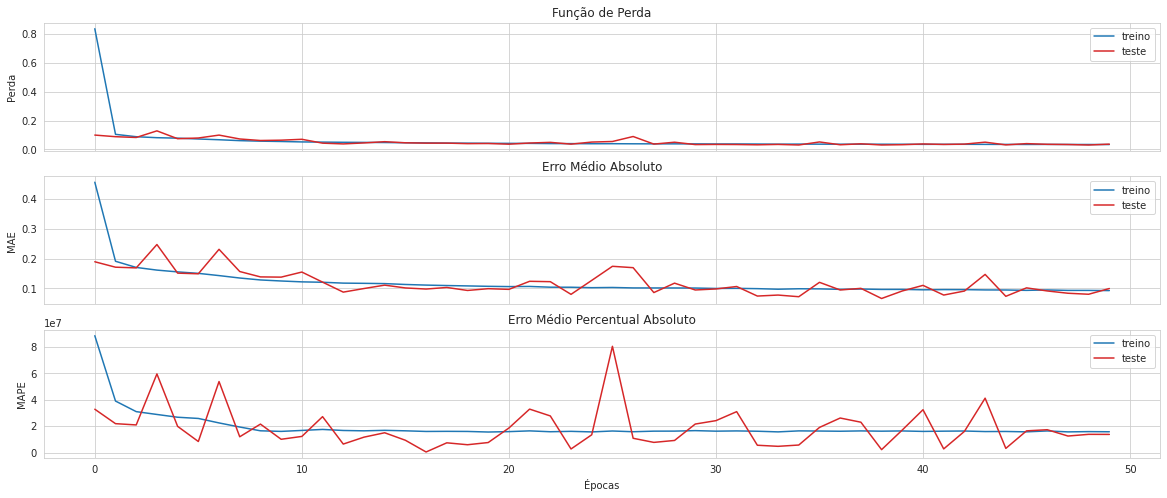

In [18]:
#@title Plot das Métricas do Modelo
# Split variables
train_loss = lstm_history.history['loss']
test_loss = lstm_history.history['val_loss']
train_mae = lstm_history.history['MAE']
test_mae = lstm_history.history['val_MAE']
train_mape = lstm_history.history['MAPE']
test_mape = lstm_history.history['val_MAPE']
epoch = range(len(test_mape))

# Create two subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
axs[0].plot(epoch, train_loss, 'tab:blue', label='treino')
axs[0].plot(epoch, test_loss, 'tab:red', label='teste')
axs[0].set_title('Função de Perda')
axs[0].set(ylabel='Perda')
# axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(epoch, train_mae, 'tab:blue', label='treino')
axs[1].plot(epoch, test_mae, 'tab:red', label='teste')
axs[1].set_title('Erro Médio Absoluto')
axs[1].set(ylabel='MAE')
# axs[1].set_ylim([0, 2])
axs[1].legend()

axs[2].plot(epoch, train_mape, 'tab:blue', label='treino')
axs[2].plot(epoch, test_mape, 'tab:red', label='teste')
axs[2].set_title('Erro Médio Percentual Absoluto')
axs[2].set(ylabel='MAPE')
# axs[2].set_ylim([0, 2])
axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel='Épocas')

for ax in axs.flat:
    ax.label_outer()

plt.show()

# DNN

A rede é composta por uma camada de entrada de 128 nós com função de ativação relu, uma camada escondida (intermediária) com 128 nós e uma camada de saida de 1 nó.

A rede é treinada por 50 épocas e modelo com o menor erro de validação é salvo.

In [20]:
#@title Criar, compilar e treinar o modelo
# Save with the lowest oss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'drive/My Drive/Models/best_model_option_dnn.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

# Define de model
dnn_model = tf.keras.Sequential([
  feature_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

# Compile
dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="MAE", dtype=None),
             tf.keras.metrics.MeanAbsolutePercentageError(name="MAPE", dtype=None)]
)

# Train the model
dnn_history = dnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
13730/13735 [============================>.] - ETA: 0s - loss: 0.1487 - MAE: 0.1943 - MAPE: 39062188.0000WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'option': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'X': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'expire': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'option_type': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=string>, 'T': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'S': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'return': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=float64>, 'r': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'sigma': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=float64>, 'bs': <tf.Tensor 'ExpandDims_3:0' sh

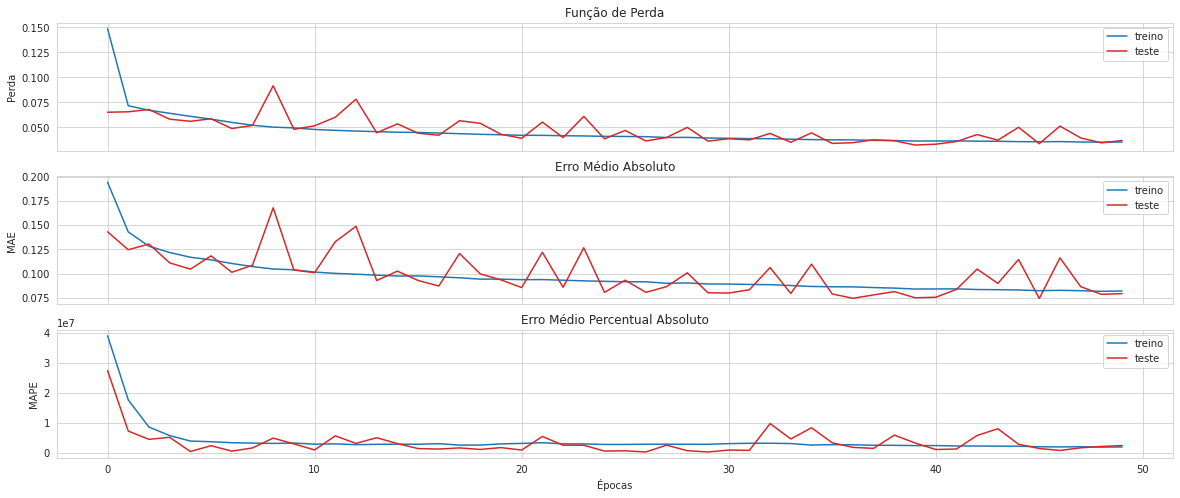

In [21]:
#@title Plot das Métricas do Modelo
# Split variables
train_loss = dnn_history.history['loss']
test_loss = dnn_history.history['val_loss']
train_mae = dnn_history.history['MAE']
test_mae = dnn_history.history['val_MAE']
train_mape = dnn_history.history['MAPE']
test_mape = dnn_history.history['val_MAPE']
epoch = range(len(test_mape))

# Create two subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
axs[0].plot(epoch, train_loss, 'tab:blue', label='treino')
axs[0].plot(epoch, test_loss, 'tab:red', label='teste')
axs[0].set_title('Função de Perda')
axs[0].set(ylabel='Perda')
# axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(epoch, train_mae, 'tab:blue', label='treino')
axs[1].plot(epoch, test_mae, 'tab:red', label='teste')
axs[1].set_title('Erro Médio Absoluto')
axs[1].set(ylabel='MAE')
# axs[1].set_ylim([0, 2])
axs[1].legend()

axs[2].plot(epoch, train_mape, 'tab:blue', label='treino')
axs[2].plot(epoch, test_mape, 'tab:red', label='teste')
axs[2].set_title('Erro Médio Percentual Absoluto')
axs[2].set(ylabel='MAPE')
# axs[2].set_ylim([0, 2])
axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel='Épocas')

for ax in axs.flat:
    ax.label_outer()

plt.show()

# Predição

Predição dos valores na bases de treino, teste e validação

In [31]:
#@title Carregando os melhores modelos 
# load model 
lstm_model.load_weights('drive/My Drive/Models/best_model_option_lstm.h5')
dnn_model.load_weights('drive/My Drive/Models/best_model_option_dnn.h5')

In [32]:
#@title Predição nas bases treino, test e validação
train['lstm'] = lstm_model.predict(train_ds)
test['lstm'] = lstm_model.predict(test_ds)
val['lstm'] = lstm_model.predict(val_ds)

train['dnn'] = dnn_model.predict(train_ds)
test['dnn'] = dnn_model.predict(test_ds)
val['dnn'] = dnn_model.predict(val_ds)

# Salvando dados

Salvando os dados para analises

In [33]:
train

,date,option,value,X,expire,option_type,T,S,return,r,sigma,bs,delta_bs,stratify,lstm,dnn
0,2014-01-01,PETRA1,0.00,0.00,2015-01-19,call,0.000000,0.00,0.000000,0.0,0.000000,0.00,0,train,0.263209,-0.008808
1,2014-01-02,PETRA1,0.00,0.00,2015-01-19,call,0.000000,0.00,0.000000,0.0,0.000000,0.00,0,train,0.028344,-0.005091
2,2014-01-03,PETRA1,0.00,0.00,2015-01-19,call,0.000000,0.00,0.000000,0.0,0.000000,0.00,0,train,0.029741,-0.005091
3,2014-01-04,PETRA1,0.00,0.00,2015-01-19,call,0.000000,0.00,0.000000,0.0,0.000000,0.00,0,train,0.029741,-0.008808
4,2014-01-05,PETRA1,0.00,0.00,2015-01-19,call,0.000000,0.00,0.000000,0.0,0.000000,0.00,0,train,0.029741,3.889356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404195,2014-02-15,PETRX391,0.00,0.00,2019-12-16,put,0.000000,0.00,0.000000,0.0,0.000000,0.00,0,train,0.029741,0.037050
404196,2019-11-14,PETRX391,9.27,38.81,2019-12-16,put,0.079365,29.30,-0.020271,4.9,34.677451,9.36,100,train,3.794776,-0.008808
404197,2019-11-18,PETRX391,9.27,38.81,2019-12-16,put,0.075397,29.08,-0.007537,4.9,35.177572,9.59,100,train,0.793616,-0.005091
404198,2019-12-12,PETRX391,8.00,38.81,2019-12-16,put,0.007937,30.97,0.018576,4.9,28.735086,7.82,100,train,0.029740,-0.008808


# Gráficos das opções

Para comparação foram escolhidas aleatóriamente 10 opções (5 opções de compra e 5 opções de venda) da base de teste.

In [ ]:
#@title Função de comparação
from sklearn.metrics import mean_squared_error

def predict(model, data, options, expire):

    # Select options
    df = data[(data['option'] == options) & (data['expire'] == expire)]

    # Convert to dataset
    ds = df_to_dataset(df, shuffle=False)

    # Predict values
    pred = model.predict(ds)

    rmse_bs = np.sqrt(mean_squared_error(df['value'],df['bs']))
    rmse_dnn = np.sqrt(mean_squared_error(df['value'], pred))
    if rmse_dnn < rmse_bs:
        result = 'LSTM'
    else:
        result = 'Black-Scholes'

    fig, axs = plt.subplots(figsize=(20, 4))
    axs.plot(df.index, pred, 'tab:blue', label='LSTM')
    axs.plot(df.index, df['bs'], 'tab:green', label='BS')
    axs.plot(df.index, df['value'], 'tab:red', label=options)
    axs.set_title(f'{options} - Black-Scholes:{rmse_bs:.4f}, LSTM:{rmse_dnn:.4f}, Melhor modelo {result}')
    axs.set(ylabel='Valor R$')
    axs.set(xlabel='data')
    axs.legend()

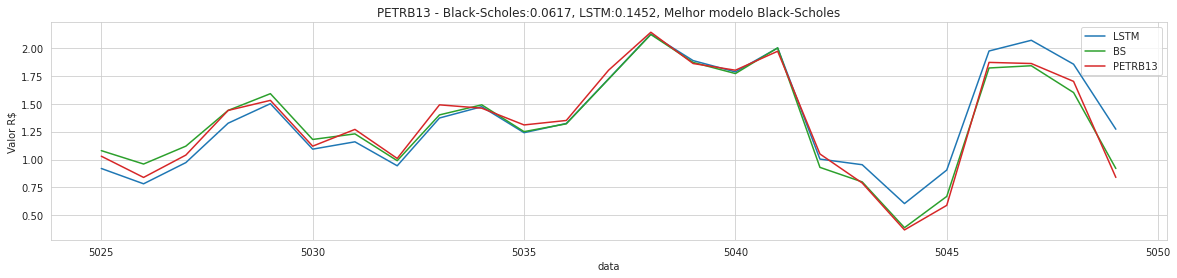

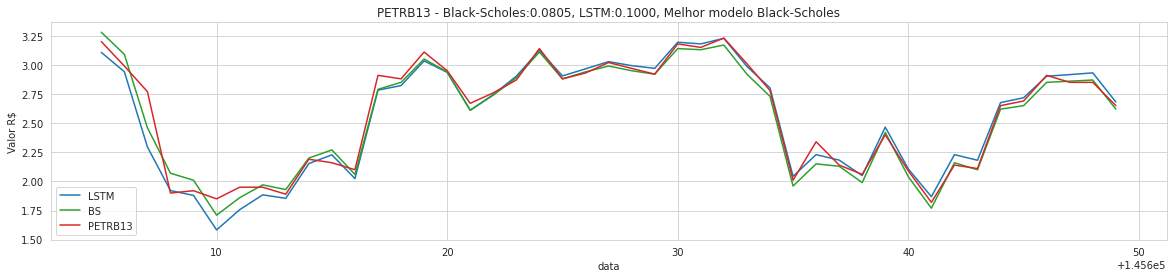

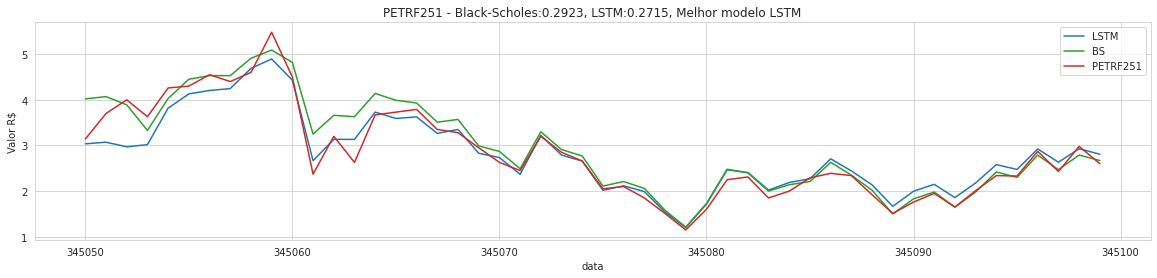

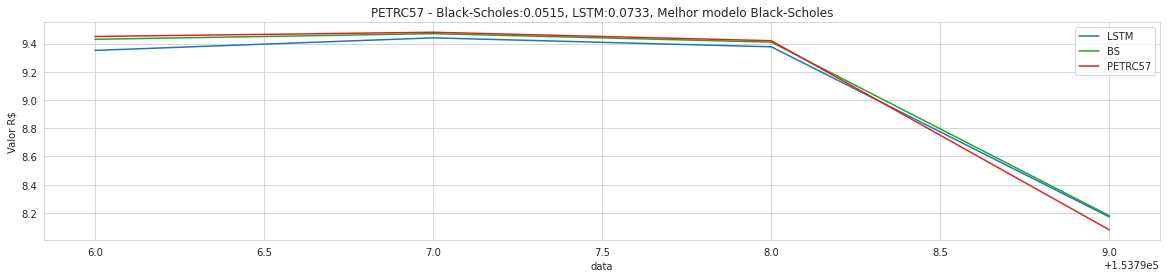

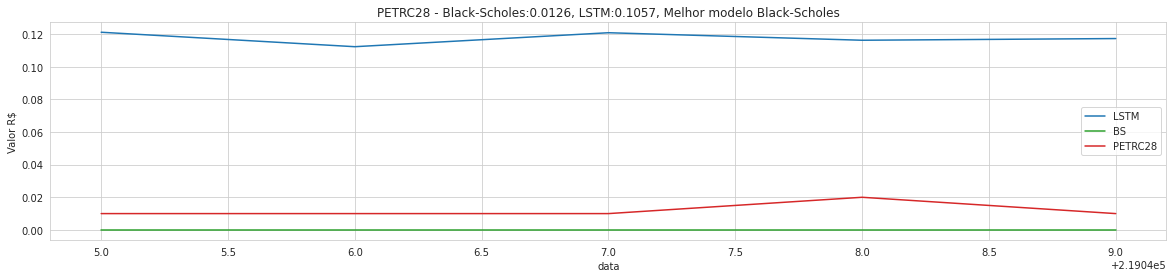

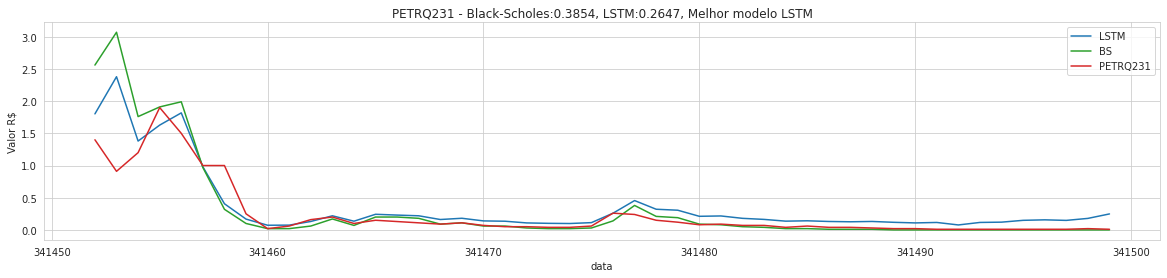

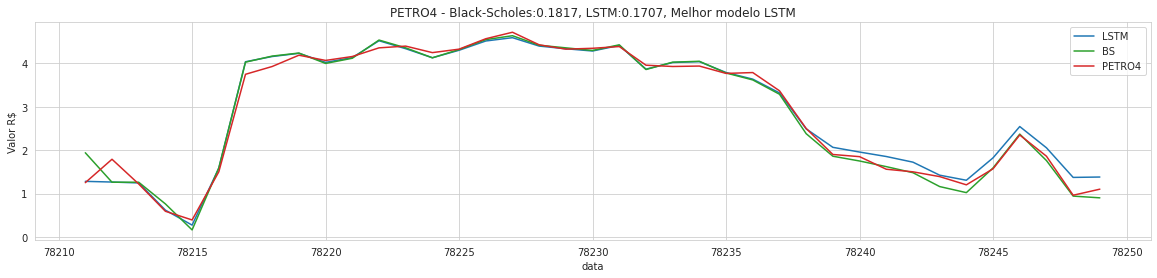

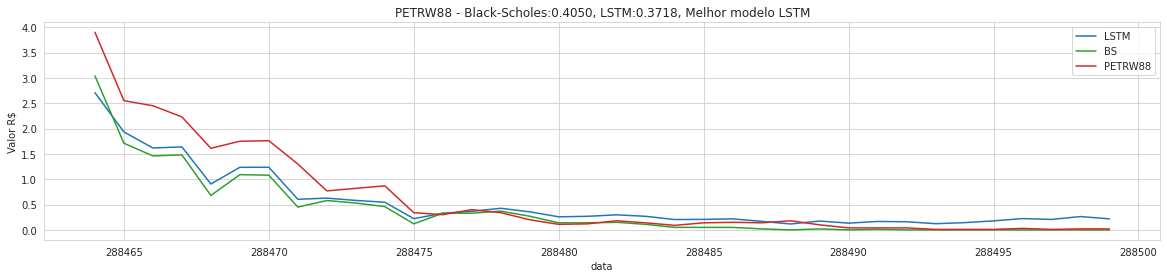

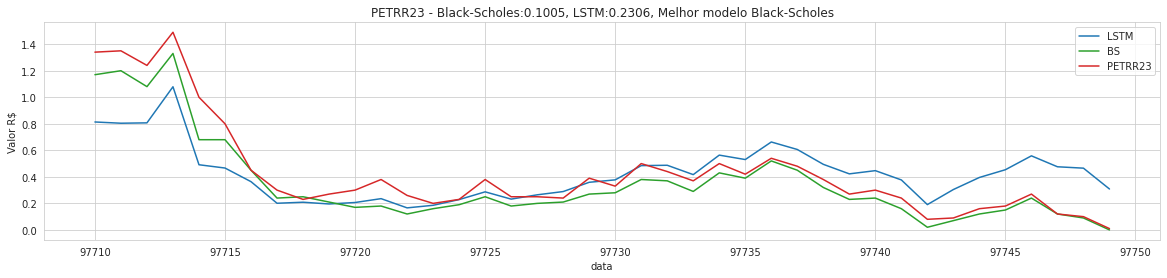

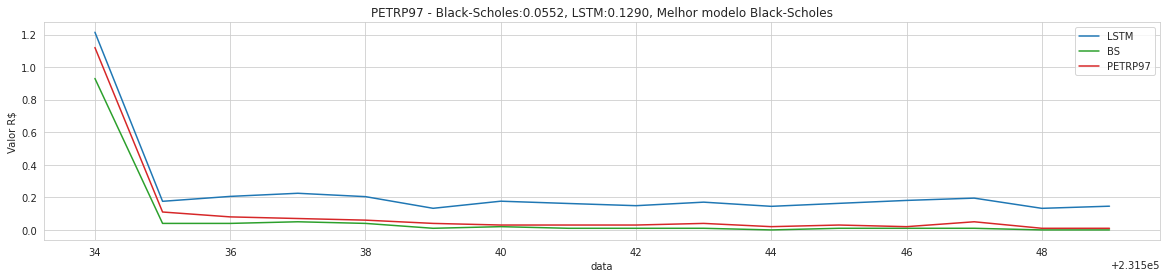

In [ ]:
#@title
for option_type in ['call', 'put']:
    
    options = test.loc[test['option_type'] == option_type, ['option', 'expire']].drop_duplicates()

    for _ in range(5):

        rand = np.random.randint(options.shape[0])

        predict(
            model,
            data[data['value'] != 0],
            options.iloc[rand, 0],
            options.iloc[rand, 1]
        )

In [ ]:
#@title Salvar os dados para comparação com outros modelos
train.to_csv('/content/drive/My Drive/Datasets/train_pred.csv', index=False)
test.to_csv('/content/drive/My Drive/Datasets/test_pred.csv', index=False)
val.to_csv('/content/drive/My Drive/Datasets/val_pred.csv', index=False)